# Home Credit Risk Analysis

This project analyzes the **Home Credit Default Risk** dataset. The objective is to develop a predictive model that identifies clients' loan repayment ability.

In [39]:

# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:

# Load Data
file_path = "/content/drive/MyDrive/Colab Notebooks/Capstone Projects/application_train.csv"  # Replace with your dataset path
train_data = pd.read_csv(file_path)


# Load Data
file_path1 = "/content/drive/MyDrive/Colab Notebooks/Capstone Projects/application_test.csv"  # Replace with your dataset path
test_data = pd.read_csv(file_path1)


In [42]:

# Exploring Metadata
missing_info = train_data.isnull().mean().reset_index()
missing_info.columns = ['column', 'missing_fraction']
missing_info = missing_info[missing_info['missing_fraction'] > 0]

print("Columns with missing values:")
print(missing_info)


Columns with missing values:
                         column  missing_fraction
9                   AMT_ANNUITY          0.000039
10              AMT_GOODS_PRICE          0.000904
11              NAME_TYPE_SUITE          0.004201
21                  OWN_CAR_AGE          0.659908
28              OCCUPATION_TYPE          0.313455
..                          ...               ...
117   AMT_REQ_CREDIT_BUREAU_DAY          0.135016
118  AMT_REQ_CREDIT_BUREAU_WEEK          0.135016
119   AMT_REQ_CREDIT_BUREAU_MON          0.135016
120   AMT_REQ_CREDIT_BUREAU_QRT          0.135016
121  AMT_REQ_CREDIT_BUREAU_YEAR          0.135016

[67 rows x 2 columns]


In [43]:

# Handling Missing Values
train_data_imputed = train_data.copy()
for col in train_data_imputed.columns:
    if train_data_imputed[col].dtype in ['float64', 'int64']:
        train_data_imputed[col].fillna(train_data_imputed[col].mean(), inplace=True)

print("Any NA in data:", train_data_imputed.isna().any().any())


<ipython-input-43-09d637c5b782>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data_imputed[col].fillna(train_data_imputed[col].mean(), inplace=True)


Any NA in data: True


In [44]:
# Addressing Imbalance in TARGET
target_col = 'TARGET'
print("Imbalance in TARGET:\n", train_data_imputed[target_col].value_counts())


Imbalance in TARGET:
 TARGET
0    282686
1     24825
Name: count, dtype: int64


In [45]:
pip install imbalanced-learn


In [46]:
# Balance the dataset using Random Over Sampling
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=123)
X_resampled, y_resampled = ros.fit_resample(
    train_data_imputed.drop(target_col, axis=1),
    train_data_imputed[target_col]
)

# Combine resampled data into a balanced DataFrame
balanced_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=[target_col])], axis=1)

# Check the distribution of the TARGET column after balancing
print("Balanced TARGET:\n", balanced_data[target_col].value_counts())


Balanced TARGET:
 TARGET
1    282686
0    282686
Name: count, dtype: int64


In [47]:

# Feature Engineering
balanced_data['income_to_credit_ratio'] = balanced_data['AMT_INCOME_TOTAL'] / balanced_data['AMT_CREDIT']
balanced_data['age_years'] = balanced_data['DAYS_BIRTH'] / -365
balanced_data = balanced_data[(balanced_data['income_to_credit_ratio'] < balanced_data['income_to_credit_ratio'].quantile(0.99)) &
                               (balanced_data['age_years'] > 18)]


In [48]:

# Splitting Data into Train and Test
X = balanced_data.drop(target_col, axis=1)
y = balanced_data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


#Original Model
1. Logistics Regression
2. Random Forest
 Models here were compared with each other at the end to see which performed better. The best model will be used for predicting against the test data.

# Final Output

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC: 0.6196882957931339
Random Forest AUC: 0.9999779630126524


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost AUC: 0.8436432964357585


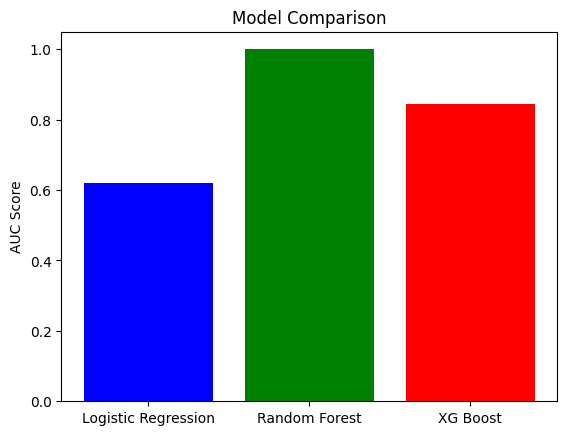

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Encode categorical variables
categorical_cols = X_train.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=123)
log_model.fit(X_train, y_train)
log_preds = log_model.predict_proba(X_test)[:, 1]
log_auc = roc_auc_score(y_test, log_preds)
print("Logistic Regression AUC:", log_auc)

# Random Forest
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_preds)
print("Random Forest AUC:", rf_auc)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_preds)
print("XGBoost AUC:", xgb_auc)

# Compare Models
models = ['Logistic Regression', 'Random Forest', 'XG Boost']
auc_scores = [log_auc, rf_auc, xgb_auc]
plt.bar(models, auc_scores, color=['blue', 'green', 'red'])
plt.ylabel("AUC Score")
plt.title("Model Comparison")
plt.show()



# Conclusion
After training and testing, compare the models' performance on the test dataset. Use the AUC and accuracy to determine the best-performing model and interpret its results.
    

In [61]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming the test set is named X_test_raw and contains SK_ID_CURR
X_test_raw = test_data  # Replace with your actual test dataset file path

# Encode categorical variables in the test set
categorical_cols = X_test_raw.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_test_raw[col] = le.fit_transform(X_test_raw[col].astype(str))  # Ensure all are strings
    label_encoders[col] = le

# Feature Engineering: Recreate features like in training
X_test_raw['income_to_credit_ratio'] = X_test_raw['AMT_INCOME_TOTAL'] / X_test_raw['AMT_CREDIT']
X_test_raw['age_years'] = X_test_raw['DAYS_BIRTH'] / -365

# Retain SK_ID_CURR for the submission
sk_id_curr = X_test_raw['SK_ID_CURR']

# Drop SK_ID_CURR and align columns to match the trained model's features
X_test_raw = X_test_raw.drop('SK_ID_CURR', axis=1)
X_test = X_test_raw.reindex(columns=rf_model.feature_names_in_, fill_value=0)

# Use the trained model to predict probabilities
rf_preds = rf_model.predict_proba(X_test)[:, 1]

# Create the submission DataFrame
submission = pd.DataFrame({
    'SK_ID_CURR': sk_id_curr,
    'TARGET': rf_preds
})

# Save to CSV
submission_file = "submission.csv"
submission.to_csv(submission_file, index=False)

print(f"Submission file saved as {submission_file}")


Submission file saved as submission.csv


#OUTCOME (RESULTS)
Below shows the performance of the models. Kaggle provided these models a 0.71 score on both Private and Public submissions

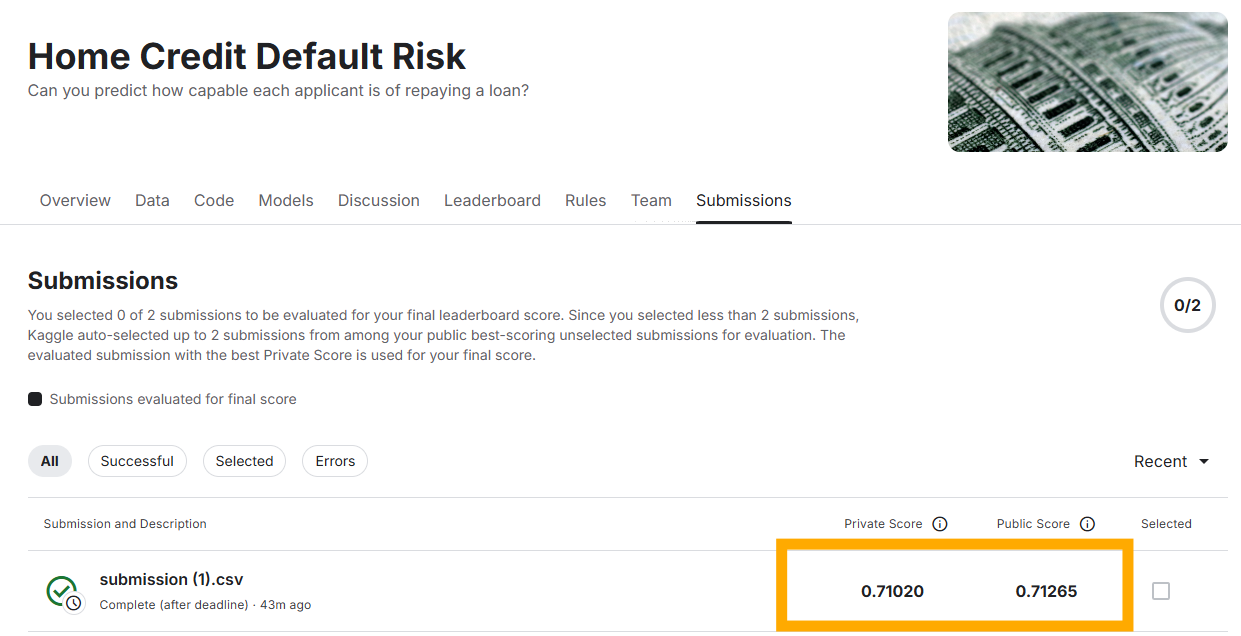

In [63]:
# replace ###### with your file name
# make sure you have your google drive mounted.


!cp "/content/drive/MyDrive/Colab Notebooks/Home_credit_risk.ipynb" ./
!jupyter nbconvert --to html "Home_credit_risk.ipynb"

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/Home_credit_risk.ipynb': No such file or directory
[NbConvertApp] WARNING | pattern 'Home_credit_risk.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    A